In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# NB201
from nas_201_api import NASBench201API as API

from ntk import get_ntk_n
from linear_region_counter import Linear_Region_Collector

import scipy.stats as stats
import matplotlib.pyplot as plt

import tqdm

# custom
from custom_models import get_cell_based_tiny_net
from custom_modules import QConv

In [8]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='../../configs/nas-benchmark/algos/RANDOM.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
# parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=0, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument("--arch_nas_dataset", type=str, default='../../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=50, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")

parser.add_argument("--train_config_path", type=str, default='../../configs/nas-benchmark/CIFAR.config', help="The path to the configuration.")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

76322
Namespace(arch_nas_dataset='../../NAS-Bench-201-v1_1-096897.pth', channel=3, config_path='../../configs/nas-benchmark/algos/RANDOM.config', data_path='../../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=50, rand_seed=76322, save_dir='./results/tmp', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, train_config_path='../../configs/nas-benchmark/CIFAR.config', workers=0)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
# torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 16
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 50
rand_seed        : 85864
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
train_config_path : ../../configs/nas-benchmark/CIFAR.config
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) with ntk_score=-163.105349222819, lr_score=300.0
184.73025 1.288506



Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|)
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|avg_pool_3x3~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=13403
cifar10-valid  FLOP=184.73 M, Params=1.289 MB, latency=20.98 ms.
cifar10-valid  train : [loss = 0.001, top1 = 99.99%], valid : [loss = 0.495, top1 = 90.41%]
cifar10        FLOP=184.73 M, Params=1.289 MB, latency=20.98 ms.
cifar10        train : [loss = 0.0

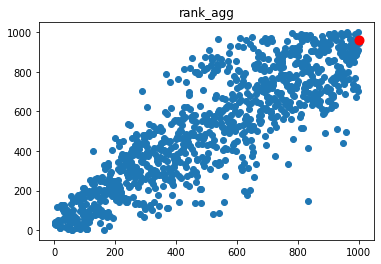

0.6811262981586923 3.562602824939169e-228


In [6]:
if 'api' not in vars():
    if args.arch_nas_dataset is None:
        api = None
    else:
        api = API(xargs.arch_nas_dataset)

fp_results = torch.load("./c3n5_1000samples.pth")
archs = fp_results['archs']
fp_ntk_scores = fp_results['ntk_scores']
fp_lr_scores = fp_results['lr_scores']
api_valid_accs = fp_results['api_valid_accs']
api_flops = fp_results['api_flops']
api_params = fp_results['api_params']

rank_ntk, rank_lr, rank_flops, rank_params = stats.rankdata(fp_ntk_scores), stats.rankdata(fp_lr_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

l = len(fp_ntk_scores)

rank_agg = np.log(rank_ntk/l) + np.log(rank_lr/l) + np.log(rank_flops/l)


best_idx = np.argmax(rank_agg)
best_arch, best_ntk_score, best_lr_score, flops, params = archs[best_idx], fp_ntk_scores[best_idx], fp_lr_scores[best_idx], api_flops[best_idx], api_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with ntk_score={:}, lr_score={:}".format(best_arch, best_ntk_score, best_lr_score))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

# Train

In [5]:
def train_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_inputs = base_inputs.cuda(non_blocking=True)
        base_targets = base_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_inputs = arch_inputs.cuda(non_blocking=True)
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [ ]:
w, a = 32, 32

xxargs = deepcopy(args)
xxargs.save_dir = os.path.join(xxargs.save_dir, "train_w{:}_a{:}".format(w,a))
xxargs.workers = 16

logger = prepare_logger(xxargs)

cifar_train_config_path = xxargs.train_config_path

## prepare dataloader
train_data, test_data, xshape, class_num = get_datasets(xxargs.dataset, xxargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)

train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=xxargs.workers,
        pin_memory=True,)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=config.batch_size,
            shuffle=True,
            num_workers=xxargs.workers,
            pin_memory=True,)

logger.log("||||||| {:10s} ||||||| Train-Loader-Num={:}, Test-Loader-Num={:}, batch size={:}".format(
            xxargs.dataset, len(train_loader), len(test_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xxargs.dataset, config))

## prepare model, optim, loss
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)
network = search_model.cuda()
network.arch_cache = best_arch

for m in network.modules():
    if isinstance(m, QConv):
        m.set_q_range(w, a)

for layer in network.children(): # reset params
    if hasattr(layer, 'reset_parameters'):
        layer.reset_parameters()
w_optimizer, w_scheduler, criterion = get_optim_scheduler(network.parameters(), config)

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies = 0, {"best": -1}

start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    search_w_loss, search_w_top1, search_w_top5 = train_func_one_arch(
        train_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xxargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        test_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )

    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xxargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "valid_accuracies": valid_accuracies,
            "arch":search_model.arch_cache,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xxargs),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest test accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()

Main Function with logger : Logger(dir=results/tmp/train_w32_a32, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 3
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 50
rand_seed        : 68245
save_dir         : ./results/tmp/train_w32_a32
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
train_config_path : ../../configs/nas-benchmark/CIFAR.config
workers          : 16
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/CIFAR.config
Configure(scheduler=

*SEARCH* [2023-01-09 07:20:24] [004-200][100/196] Time 0.32 (0.37) Data 0.00 (0.05) Base [Loss 1.126 (1.214)  Prec@1 59.77 (56.16) Prec@5 94.92 (94.80)]
*SEARCH* [2023-01-09 07:20:40] [004-200][150/196] Time 0.32 (0.35) Data 0.00 (0.04) Base [Loss 1.195 (1.205)  Prec@1 58.20 (56.45) Prec@5 93.36 (94.81)]
*SEARCH* [2023-01-09 07:20:54] [004-200][195/196] Time 0.12 (0.34) Data 0.00 (0.03) Base [Loss 0.944 (1.200)  Prec@1 62.50 (56.67) Prec@5 100.00 (94.89)]
[004-200] searching : loss=1.20, accuracy@1=56.67%, accuracy@5=94.89%, time-cost=342.8 s
[004-200] evaluate  : loss=1.24, accuracy@1=55.00%, accuracy@5=94.74%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth
<<<--->>> The 004-200-th epoch 

*SEARCH* [2023-01-09 07:27:53] [009-200][195/196] Time 0.13 (0.35) Data 0.00 (0.02) Base [Loss 0.809 (0.988)  Prec@1 72.50 (64.48) Prec@5 97.50 (96.87)]
[009-200] searching : loss=0.99, accuracy@1=64.48%, accuracy@5=96.87%, time-cost=691.2 s
[009-200] evaluate  : loss=1.08, accuracy@1=61.70%, accuracy@5=96.00%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 010-200-th epoch] Time Left: [04:19:29], LR=0.0993844170297569
*SEARCH* [2023-01-09 07:28:11] [010-200][000/196] Time 4.62 (4.62) Data 4.23 (4.23) Base [Loss 0.998 (0.998)  Prec@1 64.06 (64.06) Prec@5 93.75 (93.75)]
*SEARCH* [2023-01-09 07:28:28] [010-200][050/196] Time 0.32 (0.41) Data 0.00 (0.08) Base [Loss 1.021 (0.973) 

*SEARCH* [2023-01-09 07:35:04] [015-200][000/196] Time 4.97 (4.97) Data 4.57 (4.57) Base [Loss 0.783 (0.783)  Prec@1 72.66 (72.66) Prec@5 98.83 (98.83)]
*SEARCH* [2023-01-09 07:35:21] [015-200][050/196] Time 0.33 (0.42) Data 0.00 (0.09) Base [Loss 0.874 (0.887)  Prec@1 69.14 (68.73) Prec@5 96.88 (97.49)]
*SEARCH* [2023-01-09 07:35:38] [015-200][100/196] Time 0.33 (0.38) Data 0.00 (0.05) Base [Loss 0.990 (0.890)  Prec@1 64.84 (68.61) Prec@5 97.66 (97.45)]
*SEARCH* [2023-01-09 07:35:54] [015-200][150/196] Time 0.32 (0.36) Data 0.00 (0.03) Base [Loss 0.843 (0.894)  Prec@1 71.48 (68.37) Prec@5 97.27 (97.45)]
*SEARCH* [2023-01-09 07:36:09] [015-200][195/196] Time 0.15 (0.36) Data 0.00 (0.02) Base [Loss 0.925 (0.893)  Prec@1 67.50 (68.43) Prec@5 100.00 (97.54)]
[015-200] searching : loss=0.89, accuracy@1=68.43%, accuracy@5=97.54%, time-cost=1107.1 s
[015-200] evaluate  : loss=1.02, accuracy@1=63.33%, accuracy@5=96.77%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, dele

[020-200] evaluate  : loss=0.95, accuracy@1=66.78%, accuracy@5=97.20%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 021-200-th epoch] Time Left: [04:09:24], LR=0.09730426794137727
*SEARCH* [2023-01-09 07:43:30] [021-200][000/196] Time 4.56 (4.56) Data 4.17 (4.17) Base [Loss 0.743 (0.743)  Prec@1 73.83 (73.83) Prec@5 98.05 (98.05)]
*SEARCH* [2023-01-09 07:43:47] [021-200][050/196] Time 0.34 (0.42) Data 0.00 (0.08) Base [Loss 0.772 (0.824)  Prec@1 71.48 (70.99) Prec@5 98.83 (97.82)]
*SEARCH* [2023-01-09 07:44:04] [021-200][100/196] Time 0.33 (0.38) Data 0.00 (0.04) Base [Loss 0.792 (0.828)  Prec@1 70.70 (70.85) Prec@5 98.05 (97.81)]
*SEARCH* [2023-01-09 07:44:20] [021-200][150

*SEARCH* [2023-01-09 07:50:29] [026-200][000/196] Time 4.70 (4.70) Data 4.31 (4.31) Base [Loss 0.884 (0.884)  Prec@1 69.92 (69.92) Prec@5 97.27 (97.27)]
*SEARCH* [2023-01-09 07:50:45] [026-200][050/196] Time 0.32 (0.41) Data 0.00 (0.08) Base [Loss 0.871 (0.800)  Prec@1 70.70 (71.87) Prec@5 96.09 (97.68)]
*SEARCH* [2023-01-09 07:51:01] [026-200][100/196] Time 0.32 (0.37) Data 0.00 (0.04) Base [Loss 0.784 (0.803)  Prec@1 71.48 (71.75) Prec@5 98.83 (97.83)]
*SEARCH* [2023-01-09 07:51:17] [026-200][150/196] Time 0.32 (0.35) Data 0.00 (0.03) Base [Loss 0.870 (0.804)  Prec@1 67.19 (72.00) Prec@5 97.66 (97.77)]
*SEARCH* [2023-01-09 07:51:32] [026-200][195/196] Time 0.15 (0.35) Data 0.00 (0.02) Base [Loss 0.735 (0.799)  Prec@1 75.00 (72.18) Prec@5 98.75 (97.82)]
[026-200] searching : loss=0.80, accuracy@1=72.18%, accuracy@5=97.82%, time-cost=1883.4 s
[026-200] evaluate  : loss=0.88, accuracy@1=69.06%, accuracy@5=97.53%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delet

*SEARCH* [2023-01-09 07:59:00] [032-200][000/196] Time 5.10 (5.10) Data 4.73 (4.73) Base [Loss 0.771 (0.771)  Prec@1 73.05 (73.05) Prec@5 98.05 (98.05)]
*SEARCH* [2023-01-09 07:59:16] [032-200][050/196] Time 0.32 (0.42) Data 0.00 (0.09) Base [Loss 0.765 (0.772)  Prec@1 70.70 (72.96) Prec@5 97.27 (98.05)]
*SEARCH* [2023-01-09 07:59:32] [032-200][100/196] Time 0.32 (0.37) Data 0.00 (0.05) Base [Loss 0.699 (0.767)  Prec@1 78.12 (73.24) Prec@5 98.44 (98.01)]
*SEARCH* [2023-01-09 07:59:49] [032-200][150/196] Time 0.34 (0.36) Data 0.00 (0.03) Base [Loss 0.750 (0.761)  Prec@1 74.22 (73.57) Prec@5 98.83 (98.10)]
*SEARCH* [2023-01-09 08:00:04] [032-200][195/196] Time 0.12 (0.35) Data 0.00 (0.02) Base [Loss 0.681 (0.764)  Prec@1 78.75 (73.40) Prec@5 97.50 (98.11)]
[032-200] searching : loss=0.76, accuracy@1=73.40%, accuracy@5=98.11%, time-cost=2314.5 s
[032-200] evaluate  : loss=0.83, accuracy@1=71.11%, accuracy@5=97.75%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delet

[037-200] evaluate  : loss=0.83, accuracy@1=70.94%, accuracy@5=97.79%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 038-200-th epoch] Time Left: [03:47:59], LR=0.0913540287137281
*SEARCH* [2023-01-09 08:07:18] [038-200][000/196] Time 5.07 (5.07) Data 4.62 (4.62) Base [Loss 0.753 (0.753)  Prec@1 74.22 (74.22) Prec@5 98.83 (98.83)]
*SEARCH* [2023-01-09 08:07:34] [038-200][050/196] Time 0.32 (0.42) Data 0.00 (0.09) Base [Loss 0.754 (0.741)  Prec@1 73.44 (74.45) Prec@5 98.44 (98.22)]
*SEARCH* [2023-01-09 08:07:50] [038-200][100/196] Time 0.32 (0.37) Data 0.00 (0.05) Base [Loss 0.681 (0.744)  Prec@1 77.73 (74.22) Prec@5 98.05 (98.15)]
*SEARCH* [2023-01-09 08:08:06] [038-200][150/

*SEARCH* [2023-01-09 08:14:53] [043-200][100/196] Time 0.35 (0.39) Data 0.00 (0.04) Base [Loss 0.671 (0.742)  Prec@1 75.39 (74.16) Prec@5 98.44 (98.09)]
*SEARCH* [2023-01-09 08:15:10] [043-200][150/196] Time 0.35 (0.37) Data 0.00 (0.03) Base [Loss 0.619 (0.737)  Prec@1 77.34 (74.35) Prec@5 99.61 (98.14)]
*SEARCH* [2023-01-09 08:15:26] [043-200][195/196] Time 0.16 (0.37) Data 0.00 (0.02) Base [Loss 0.891 (0.736)  Prec@1 66.25 (74.44) Prec@5 97.50 (98.13)]
[043-200] searching : loss=0.74, accuracy@1=74.44%, accuracy@5=98.13%, time-cost=3087.1 s
[043-200] evaluate  : loss=0.85, accuracy@1=71.08%, accuracy@5=97.55%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 044-200-th epoch] 

*SEARCH* [2023-01-09 08:22:58] [049-200][050/196] Time 0.32 (0.41) Data 0.00 (0.08) Base [Loss 0.664 (0.718)  Prec@1 77.73 (75.67) Prec@5 99.22 (98.41)]
*SEARCH* [2023-01-09 08:23:15] [049-200][100/196] Time 0.32 (0.36) Data 0.00 (0.04) Base [Loss 0.698 (0.704)  Prec@1 76.95 (75.75) Prec@5 98.83 (98.50)]
*SEARCH* [2023-01-09 08:23:31] [049-200][150/196] Time 0.32 (0.35) Data 0.00 (0.03) Base [Loss 0.593 (0.709)  Prec@1 78.91 (75.57) Prec@5 98.83 (98.42)]
*SEARCH* [2023-01-09 08:23:45] [049-200][195/196] Time 0.14 (0.35) Data 0.00 (0.02) Base [Loss 0.758 (0.712)  Prec@1 75.00 (75.48) Prec@5 97.50 (98.39)]
[049-200] searching : loss=0.71, accuracy@1=75.48%, accuracy@5=98.39%, time-cost=3506.6 s
[049-200] evaluate  : loss=0.82, accuracy@1=72.04%, accuracy@5=97.96%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last

*SEARCH* [2023-01-09 08:31:32] [055-200][100/196] Time 0.35 (0.39) Data 0.00 (0.04) Base [Loss 0.695 (0.695)  Prec@1 74.61 (75.87) Prec@5 97.27 (98.45)]
*SEARCH* [2023-01-09 08:31:49] [055-200][150/196] Time 0.36 (0.38) Data 0.00 (0.03) Base [Loss 0.684 (0.696)  Prec@1 77.34 (75.94) Prec@5 98.44 (98.46)]
*SEARCH* [2023-01-09 08:32:05] [055-200][195/196] Time 0.16 (0.37) Data 0.00 (0.02) Base [Loss 0.677 (0.698)  Prec@1 75.00 (75.79) Prec@5 97.50 (98.46)]
[055-200] searching : loss=0.70, accuracy@1=75.79%, accuracy@5=98.46%, time-cost=3925.5 s
[055-200] evaluate  : loss=0.77, accuracy@1=72.83%, accuracy@5=98.14%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 056-200-th epoch] 

*SEARCH* [2023-01-09 08:40:20] [061-200][150/196] Time 0.38 (0.40) Data 0.00 (0.03) Base [Loss 0.765 (0.685)  Prec@1 73.44 (76.24) Prec@5 98.83 (98.49)]
*SEARCH* [2023-01-09 08:40:36] [061-200][195/196] Time 0.16 (0.39) Data 0.00 (0.02) Base [Loss 0.730 (0.682)  Prec@1 70.00 (76.43) Prec@5 98.75 (98.52)]
[061-200] searching : loss=0.68, accuracy@1=76.43%, accuracy@5=98.52%, time-cost=4354.1 s
[061-200] evaluate  : loss=0.81, accuracy@1=71.71%, accuracy@5=98.29%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth

[Search the 062-200-th epoch] Time Left: [03:28:31], LR=0.07810416889260655
*SEARCH* [2023-01-09 08:40:56] [062-200][000/196] Time 5.27 (5.27) Data 4.83 (4.83) Base [Loss 0.670 (0.670

*SEARCH* [2023-01-09 08:48:45] [067-200][100/196] Time 0.33 (0.38) Data 0.00 (0.04) Base [Loss 0.606 (0.681)  Prec@1 80.47 (76.39) Prec@5 98.44 (98.45)]
*SEARCH* [2023-01-09 08:49:01] [067-200][150/196] Time 0.33 (0.36) Data 0.00 (0.03) Base [Loss 0.699 (0.676)  Prec@1 76.17 (76.55) Prec@5 98.44 (98.46)]
*SEARCH* [2023-01-09 08:49:16] [067-200][195/196] Time 0.12 (0.35) Data 0.00 (0.02) Base [Loss 0.785 (0.676)  Prec@1 68.75 (76.55) Prec@5 98.75 (98.44)]
[067-200] searching : loss=0.68, accuracy@1=76.55%, accuracy@5=98.44%, time-cost=4792.2 s
[067-200] evaluate  : loss=0.74, accuracy@1=74.95%, accuracy@5=98.29%
Find results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth
Find results/tmp/train_w32_a32/seed-68245-last-info.pth exist, delete is at first before saving
save checkpoint into results/tmp/train_w32_a32/seed-68245-last-info.pth
<<<--->>> The 067-200-th epoch 

# Metrics

In [86]:
def kaiming_normal_fanin_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def kaiming_normal_fanout_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if hasattr(m, 'bias') and m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm2d):
        if m.affine:
            nn.init.ones_(m.weight.data)
            nn.init.constant_(m.bias.data, 0.0)


def init_model(model, method='kaiming_norm_fanin'):
    if method == 'kaiming_norm_fanin':
        model.apply(kaiming_normal_fanin_init)
    elif method == 'kaiming_norm_fanout':
        model.apply(kaiming_normal_fanout_init)
    return model

def pca_eig_diag(xloader, network, num_batch=1):
    device = torch.cuda.current_device()
    network.train()
    
    with torch.no_grad():
        feat_list = []
        for i, (inputs, targets) in enumerate(xloader):
            if num_batch > 0 and i >= num_batch: break

            inputs = inputs.cuda(device=device, non_blocking=True)
            network.zero_grad()
            inputs_ = inputs.clone().cuda(device=device, non_blocking=True)
#             inputs_ = torch.randn_like(inputs)
            _ = network(inputs_)
            feat = network.last_feature_map
            feat = feat.mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
            b,c,h,w = feat.size()
            feat_list.append(feat.permute(0,2,3,1).contiguous().view(b*h*w,c))

        feat = torch.cat(feat_list, dim=0)
        m = feat.mean(dim=0, keepdim=True)
        feat = feat - m
        sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
        u, s, v = torch.svd(sigma)
        prob_s = s / s.sum()
        score = (-prob_s)*torch.log(prob_s+1e-8)
        score = score.sum()
            
        torch.cuda.empty_cache()
    
    return score.item()

def search_find_best(xloader, network, lrc_model, archs, w_a_bits, reinit=True):
    network.train()
    pca_scores, ntk_scores, lr_scores = dict(), dict(), dict()
    for w,a in w_a_bits:
        key = "w{:}a{:}".format(w,a)
        pca_scores[key] = []
        ntk_scores[key] = []
        lr_scores[key] = []
    
    for i, arch in enumerate(tqdm.tqdm(archs)):
        # random sampling
#         arch = network.module.random_genotype(True)
        network.arch_cache = arch
    
        pca_score_tmp, ntk_score_tmp, lr_score_tmp = dict(), dict(), dict()
        for w,a in w_a_bits:
            key = "w{:}a{:}".format(w,a)
            pca_score_tmp[key] = []
            ntk_score_tmp[key] = []
            lr_score_tmp[key] = []
        
        for _ in range(3):
            if reinit:
                init_model(network)
            for w,a in w_a_bits:
                key = "w{:}a{:}".format(w,a)
                for m in network.modules():
                    if isinstance(m, QConv):
                        m.set_q_range(w, a)
                # pca score
                score = pca_eig_diag(xloader, network)
                pca_score_tmp[key].append(score)
                # ntk score
                score = get_ntk_n(xloader, [network], recalbn=0, train_mode=True, num_batch=1)[0]
                ntk_score_tmp[key].append(-score)
                # lr score
                lrc_model.reinit(models=[network], seed=xargs.rand_seed)
                score = lrc_model.forward_batch_sample()
                lr_score_tmp[key].append(score)
                lrc_model.clear()
        
        
        for w,a in w_a_bits:
            key = "w{:}a{:}".format(w,a)
            pca_scores[key].append(np.mean(pca_score_tmp[key]))
            ntk_scores[key].append(np.mean(ntk_score_tmp[key]))
            lr_scores[key].append(np.mean(lr_score_tmp[key]))
        
    return pca_scores, ntk_scores, lr_scores

# Main

In [9]:
logger = prepare_logger(args)

## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))


# ## model
search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

if 'api' not in vars():
    if xargs.arch_nas_dataset is None:
        api = None
    else:
        api = API(xargs.arch_nas_dataset)
    logger.log("{:} create API = {:} done".format(time_string(), api))

    last_info, model_base_path, model_best_path = (
        logger.path("info"),
        logger.path("model"),
        logger.path("best"),
    )

network = search_model.cuda()

## LRC
lrc_model = Linear_Region_Collector(input_size=(100, 3, 3, 3), sample_batch=3, dataset=xargs.dataset, data_path=xargs.data_path, seed=xargs.rand_seed)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : ../../NAS-Bench-201-v1_1-096897.pth
channel          : 3
config_path      : ../../configs/nas-benchmark/algos/RANDOM.config
data_path        : ../../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 50
rand_seed        : 76322
save_dir         : ./results/tmp
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
train_config_path : ../../configs/nas-benchmark/CIFAR.config
workers          : 0
Python  Version  : 3.8.8 (default, Feb 24 2021, 21:46:12)  [GCC 7.3.0]
Pillow  Version  : 8.1.2
PyTorch Version  : 1.8.1
cuDNN   Version  : 8005
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
../../configs/nas-benchmark/algos/RANDOM.config
Configure(scheduler='cos', LR=0.025, eta_m

In [88]:
num_samples = 300

fp_results = torch.load("./c3n5_1000samples.pth")
archs = fp_results['archs']
fp_ntk_scores = fp_results['ntk_scores']
fp_lr_scores = fp_results['lr_scores']
api_valid_accs = fp_results['api_valid_accs']
api_flops = fp_results['api_flops']
api_params = fp_results['api_params']

w_a_bits = [(32,32),(4,4),(2,2),(1,1)]
trained_weights = torch.load("./results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth")
network.load_state_dict(trained_weights['search_model'])
pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits, reinit=False)
print(pca_scores, ntk_scores, lr_scores)

w_a_bits = [(32,32),(4,4),(2,2),(1,1)]
init_model(network)
pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits)
print(pca_scores, ntk_scores, lr_scores)

# w_a_bits = [(2,2)]
# trained_weights = torch.load("./results/tmp/train_w2_a2/checkpoint/seed-29411-basic.pth")
# network.load_state_dict(trained_weights['search_model'])
# pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits)
# print(pca_scores, ntk_scores, lr_scores)

# w_a_bits = [(2,2)]
# init_model(network)
# pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits)
# print(pca_scores, ntk_scores, lr_scores)

  0%|          | 0/1 [00:01<?, ?it/s]

[[1.000 0.335 0.564 0.814 0.938 0.861 0.857 0.674 0.359 0.494 0.296 0.694
  0.347 0.922 0.394 0.969 0.852 0.721 0.324 0.242 0.261 0.849 0.243 0.453
  0.612 0.233 0.646 0.491 0.272 0.855 0.886 0.847 0.473 0.366 0.661 0.625
  0.656 0.402 0.920 0.823 0.380 0.484 0.449 0.663 0.906 0.747 0.242 0.297
  0.194 0.337 0.357 0.231 0.411 0.794 0.722 0.960 0.672 0.335 0.325 0.521
  0.665 0.487 0.762 0.401]
 [0.335 1.000 0.655 0.187 0.262 0.397 0.232 0.313 0.752 0.305 0.756 0.616
  0.546 0.167 0.931 0.452 0.143 0.204 0.782 0.692 0.822 0.465 0.890 0.529
  0.505 0.680 0.362 0.834 0.700 0.276 0.167 0.465 0.863 0.586 0.720 0.405
  0.431 0.824 0.448 0.210 0.653 0.839 0.789 0.856 0.528 0.724 0.468 0.963
  0.622 0.838 0.818 0.827 0.445 0.171 0.622 0.455 0.214 0.725 0.833 0.624
  0.374 0.248 0.232 0.763]
 [0.564 0.655 1.000 0.714 0.661 0.584 0.449 0.498 0.887 0.351 0.647 0.957
  0.685 0.620 0.686 0.664 0.659 0.790 0.831 0.587 0.713 0.802 0.669 0.921
  0.948 0.584 0.404 0.762 0.678 0.503 0.670 0.790 0.649 0.

NameError: name 'asd' is not defined

In [85]:
feat = torch.randn((2000,12))
m = feat.mean(dim=0, keepdim=True)
feat = feat - m
sigma = torch.mm(feat.transpose(1,0),feat) / (feat.size(0))
u, s, v = torch.svd(sigma)
prob_s = s / s.sum()
print(prob_s)
score = (-prob_s)*torch.log(prob_s+1e-8)
score = score.sum()
    
print(score)

tensor([0.0953, 0.0917, 0.0893, 0.0874, 0.0869, 0.0840, 0.0838, 0.0812, 0.0780,
        0.0752, 0.0749, 0.0722])
tensor(2.4815)


In [36]:
w_a_bits = [(32,32),(4,4),(2,2)]
trained_weights = torch.load("./results/tmp/train_w32_a32/checkpoint/seed-68245-basic.pth")
network.load_state_dict(trained_weights['search_model'])
pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits)
print(pca_scores, ntk_scores, lr_scores)

w_a_bits = [(32,32),(4,4),(2,2)]
init_model(network)
pca_scores, ntk_scores, lr_scores = search_find_best(train_loader, network, lrc_model, [archs[best_idx]], w_a_bits)
print(pca_scores, ntk_scores, lr_scores)

  0%|          | 0/1 [00:00<?, ?it/s]

{'w32a32': [2.2307282288869223], 'w4a4': [2.2216827074686685], 'w2a2': [2.232145388921102]} {'w32a32': [13168784.0], 'w4a4': [13720861.333333334], 'w2a2': [12135564.333333334]} {'w32a32': [300.0], 'w4a4': [299.3333333333333], 'w2a2': [299.6666666666667]}


100%|██████████| 1/1 [00:33<00:00, 33.09s/it]

{'w32a32': [2.046016534169515], 'w4a4': [2.029487689336141], 'w2a2': [1.9883435169855754]} {'w32a32': [-303.4014383951823], 'w4a4': [-154.0976791381836], 'w2a2': [-326.6259409586589]} {'w32a32': [299.6666666666667], 'w4a4': [300.0], 'w2a2': [299.6666666666667]}


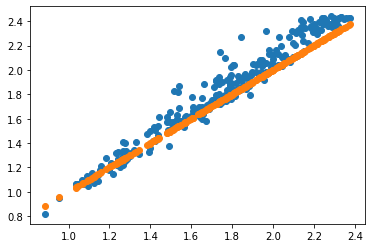

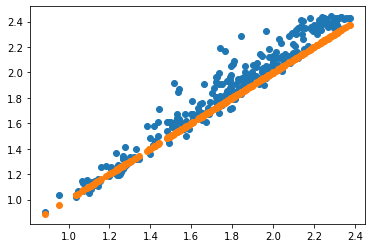

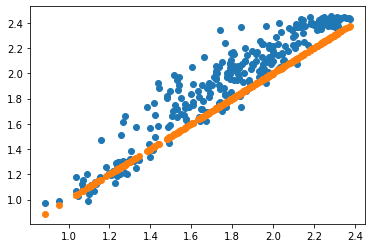

In [30]:
# plt.scatter(stats.rankdata(q_pca_scores_32),stats.rankdata(q_pca_scores_1))
# plt.xlim([-2000,10])
# plt.ylim([-2000,10])
# plt.scatter(q_ntk_scores_32,q_ntk_scores_32)
# plt.show()

target = pca_scores

plt.scatter(target["w32a32"],target["w8a8"])
plt.scatter(target["w32a32"],target["w32a32"])
# plt.xlim([-5e3, 0])
# plt.ylim([-5e3, 0])
# plt.xlim([280, 310])
# plt.ylim([280, 310])
plt.show()

plt.scatter(target["w32a32"],target["w4a4"])
plt.scatter(target["w32a32"],target["w32a32"])
# plt.xlim([-5e3, 0])
# plt.ylim([-5e3, 0])
# plt.xlim([280, 310])
# plt.ylim([280, 310])
plt.show()

plt.scatter(target["w32a32"],target["w2a2"])
plt.scatter(target["w32a32"],target["w32a32"])
# plt.xlim([-5e3, 0])
# plt.ylim([-5e3, 0])
# plt.xlim([280, 310])
# plt.ylim([280, 310])
plt.show()

In [ ]:
# %%capture
# # def get_valid_acc_from_api(api, arch):
# #     # print(api.query_by_arch(arch, "200"))
# #     index = api.query_index_by_arch(arch)
# #     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
# #     acc = 0
# #     for seed, result in results.items():
# #         acc = acc + result.get_eval('valid')['accuracy']
# #     acc = acc / len(results)
# #     return acc

# def get_results_from_api(api, arch):
#     # print(api.query_by_arch(arch, "200"))
#     index = api.query_index_by_arch(arch)
#     results = api.query_by_index(index, 'cifar10-valid', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
# #     results = api.query_by_index(index, 'cifar100', '200') # a dict of all trials for 1st net on cifar100, where the key is the seed
    
#     # valid acc
#     acc = 0
#     for seed, result in results.items():
#         acc = acc + result.get_eval('valid')['accuracy']
# #         acc = acc + result.get_eval('x-test')['accuracy']
#     acc = acc / len(results)
    
#     result = list(results.values())[0]
    
#     return acc, result.flop, result.params

# api_valid_accs, api_flops, api_params = [], [], []
# for a in archs:
#     valid_acc, flops, params = get_results_from_api(api, a)
#     api_valid_accs.append(valid_acc)
#     api_flops.append(flops)
#     api_params.append(params)

# # api_valid_accs = [get_valid_acc_from_api(api, a) for a in archs]

# Analysis

In [53]:
# fp_results = torch.load("./c3n1_1000samples.pth")
# archs = fp_results['archs']
# fp_ntk_scores = fp_results['ntk_scores']
# fp_lr_scores = fp_results['lr_scores']
# api_valid_accs = fp_results['api_valid_accs']
# api_flops = fp_results['api_flops']
# api_params = fp_results['api_params']

# torch.save({"archs":archs,
#             "ntk_scores":ntk_scores,
#             "pca_scores":pca_scores,
#             "lr_scores":lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_32_8_4_2.pth")

# torch.save({"archs":archs,
#             "fp_ntk_scores":fp_ntk_scores,
#             "fp_lr_scores":fp_lr_scores,
#             "q_ntk_scores":q_ntk_scores,
#             "q_lr_scores":q_lr_scores,
#             "api_valid_accs":api_valid_accs,
#             "api_flops":api_flops,
#             "api_params":api_params,
#            },"./c3n5_1000samples_1bit.pth")

# trained_results = torch.load("./c3n5_1000samples_4bit.pth")
# archs = trained_results['archs']
# fp_ntk_scores = trained_results['fp_ntk_scores']
# fp_lr_scores = trained_results['fp_lr_scores']
# q_ntk_scores = trained_results['q_ntk_scores']
# q_lr_scores = trained_results['q_lr_scores']
# api_valid_accs = trained_results['api_valid_accs']
# api_flops = trained_results['api_flops']
# api_params = trained_results['api_params']

RANDOM-NAS finds the best one : Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|) with ntk_score=-327.8279113769531, lr_score=300.0
117.88353 0.830426



Call query_info_str_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|) and hp=200
Call query_index_by_arch with arch=Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|)
|nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_3x3~1|+|skip_connect~0|nor_conv_1x1~1|avg_pool_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=14152
cifar10-valid  FLOP=117.88 M, Params=0.830 MB, latency=19.51 ms.
cifar10-valid  train : [loss = 0.002, top1 = 99.99%], valid : [loss = 0.421, top1 = 91.02%]
cifar10        FLOP=117.88 M, Params=0.830 MB, latency=19.51 ms.
cifar10        train : [loss = 0.

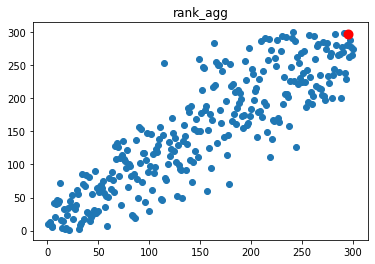

0.6877306427764505 1.3642851573445723e-70


In [52]:
q_pca_scores = np.array(pca_scores["w32a32"]) - np.array(pca_scores["w2a2"])
q_ntk_scores = ntk_scores["w32a32"]
q_lr_scores = lr_scores["w32a32"]

rank_pca, rank_ntk, rank_lr, rank_flops, rank_params = stats.rankdata(q_pca_scores), stats.rankdata(q_ntk_scores), stats.rankdata(q_lr_scores), stats.rankdata(api_flops), stats.rankdata(api_params)

l = len(q_ntk_scores)
# rank_agg = np.log(rank_pca/l)
rank_agg = np.log(rank_ntk/l) + np.log(rank_lr/l) + np.log(rank_flops/l)

idx_10p = stats.rankdata(rank_agg) > 0.9*l
tmp = q_pca_scores == np.min(q_pca_scores[idx_10p])

# best_idx = np.argmax(rank_agg)
best_idx = np.argmax(tmp)
best_arch, best_ntk_score, best_lr_score, flops, params = archs[best_idx], q_ntk_scores[best_idx], q_lr_scores[best_idx], api_flops[best_idx], api_params[best_idx]

print("RANDOM-NAS finds the best one : {:} with ntk_score={:}, lr_score={:}".format(best_arch, best_ntk_score, best_lr_score))
print(flops, params)
print("\n\n")
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
# y = api_valid_accs
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("rank_agg")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [ ]:
x = stats.rankdata(ntk_scores)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(lr_scores)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(api_flops)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

x = stats.rankdata(api_params)
y = stats.rankdata(api_valid_accs)
plt.scatter(x, y)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=4)
plt.title("metric_confidences")
plt.show()
tau, p_value = stats.kendalltau(x, y)
print(tau, p_value)

In [ ]:
index = api.query_index_by_arch(archs[0])
results = api.query_by_index(index, 'cifar10-valid', '200')
tmp = list(results.values())[0]
print(tmp)
print(tmp.params)
print(tmp.flop)